# Capítulo 8 · Selección de modelo y validación cruzada

**Objetivo:** comparar distintos modelos de regresión lineal y elegir uno adecuado usando criterios de:**  

- Complejidad (número de predictores).  
- Métricas de ajuste (AIC, BIC).  
- Desempeño predictivo mediante **validación cruzada** y conjunto de prueba.  

Trabajaremos con el dataset *Ames Housing* y las mismas variables candidatas utilizadas en capítulos anteriores.


## 8.1 Datos y variables candidatas

Cargamos el dataset, nos quedamos con variables numéricas y seleccionamos automáticamente hasta 12 predictores:

- Alta correlación absoluta con `SalePrice`.  
- Colinealidad moderada entre predictores (|ρ| ≤ 0.85).  


In [13]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm

# Localizar dataset
CANDIDATE_PATHS = [Path('data/ames_housing.csv'), Path('AmesHousing.csv')]
for p in CANDIDATE_PATHS:
    if p.exists():
        DATA_PATH = p
        break
else:
    raise FileNotFoundError('No se encontró data/ames_housing.csv ni AmesHousing.csv')

df = pd.read_csv(DATA_PATH)

target = "SalePrice"

# Numéricas y limpieza de infinitos
num_df = df.select_dtypes(include=[np.number]).replace([np.inf, -np.inf], np.nan)

# Selección automática de variables candidatas
corr_abs = num_df.corr(numeric_only=True)[target].dropna().abs().sort_values(ascending=False)
pool = [c for c in corr_abs.index if c != target][:15]

sel = []
for v in pool:
    if not sel:
        sel.append(v)
        continue
    ok = True
    for u in sel:
        r = abs(num_df[[v, u]].dropna().corr().iloc[0, 1])
        if r > 0.85:
            ok = False
            break
    if ok:
        sel.append(v)
    if len(sel) >= 12:
        break

data = num_df[[target] + sel].dropna()
X_full = data[sel].values
y = data[target].values

feature_names = sel

X_full.shape, y.shape, feature_names

((2748, 12),
 (2748,),
 ['Overall Qual',
  'Gr Liv Area',
  'Garage Cars',
  'Total Bsmt SF',
  '1st Flr SF',
  'Year Built',
  'Full Bath',
  'Year Remod/Add',
  'Garage Yr Blt',
  'Mas Vnr Area',
  'TotRms AbvGrd',
  'Fireplaces'])

Mostramos las variables candidatas ordenadas por correlación absoluta con `SalePrice`:

In [14]:
pd.DataFrame({
    "Variable": sel,
    "abs(corr SalePrice)": corr_abs[sel].values
}).round(3)

,Variable,abs(corr SalePrice)
0,Overall Qual,0.799
1,Gr Liv Area,0.707
2,Garage Cars,0.648
3,Total Bsmt SF,0.632
4,1st Flr SF,0.622
5,Year Built,0.558
6,Full Bath,0.546
7,Year Remod/Add,0.533
8,Garage Yr Blt,0.527
9,Mas Vnr Area,0.508


## 8.2 Definición de modelos candidatos

Definimos tres modelos anidados:

1. **Modelo 1 (simple):** solo la variable más correlacionada con `SalePrice`.  
2. **Modelo 2 (medio):** las dos variables más correlacionadas.  
3. **Modelo 3 (completo):** todas las variables candidatas seleccionadas (`sel`).  


In [15]:
# Definición de subconjuntos de predictores
vars_m1 = [feature_names[0]]           # 1 variable
vars_m2 = feature_names[:2]            # 2 variables
vars_m3 = feature_names[:]             # todas las candidatas

vars_m1, vars_m2, len(vars_m3)

(['Overall Qual'], ['Overall Qual', 'Gr Liv Area'], 12)

## 8.3 Partición entrenamiento / prueba

Separamos los datos en:

- 70% entrenamiento  
- 30% prueba  


In [16]:
X_train_full, X_test_full, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, random_state=42
)

X_train_full.shape, X_test_full.shape

((1923, 12), (825, 12))

Para cada modelo tomaremos las columnas correspondientes de `X_train_full` y `X_test_full`.


In [17]:
# Índices de columnas según cada conjunto de variables
idx_m1 = [feature_names.index(v) for v in vars_m1]
idx_m2 = [feature_names.index(v) for v in vars_m2]
idx_m3 = list(range(len(feature_names)))

def select_cols(X, idx):
    return X[:, idx]

X_train_m1 = select_cols(X_train_full, idx_m1)
X_test_m1  = select_cols(X_test_full, idx_m1)

X_train_m2 = select_cols(X_train_full, idx_m2)
X_test_m2  = select_cols(X_test_full, idx_m2)

X_train_m3 = select_cols(X_train_full, idx_m3)
X_test_m3  = select_cols(X_test_full, idx_m3)

X_train_m1.shape, X_train_m2.shape, X_train_m3.shape

((1923, 1), (1923, 2), (1923, 12))

## 8.4 Ajuste y criterios de información (AIC, BIC)

Usamos `statsmodels` para calcular AIC y BIC en el conjunto de entrenamiento para cada modelo.


In [18]:
def fit_sm_ols(X, y):
    X_const = sm.add_constant(X, has_constant="add")
    return sm.OLS(y, X_const).fit()

ols_m1 = fit_sm_ols(X_train_m1, y_train)
ols_m2 = fit_sm_ols(X_train_m2, y_train)
ols_m3 = fit_sm_ols(X_train_m3, y_train)

info_table = pd.DataFrame({
    "Modelo": ["M1: 1 variable", "M2: 2 variables", "M3: completo"],
    "k_pred": [X_train_m1.shape[1], X_train_m2.shape[1], X_train_m3.shape[1]],
    "AIC": [ols_m1.aic, ols_m2.aic, ols_m3.aic],
    "BIC": [ols_m1.bic, ols_m2.bic, ols_m3.bic],
}).set_index("Modelo").round(2)

info_table

,k_pred,AIC,BIC
Modelo,,,
M1: 1 variable,1,46933.14,46944.26
M2: 2 variables,2,46356.12,46372.80
M3: completo,12,45853.95,45926.26


Gráfico comparando AIC y BIC entre modelos:

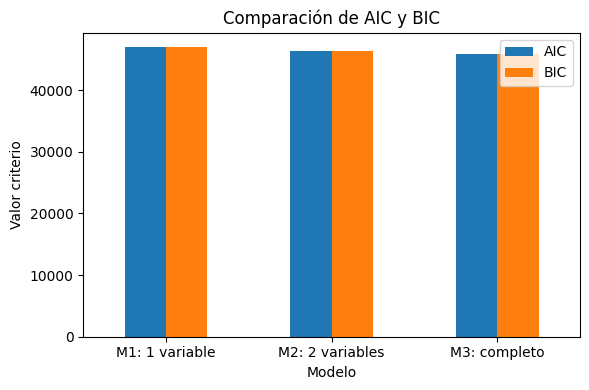

In [19]:
ax = info_table[["AIC", "BIC"]].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("Valor criterio")
ax.set_title("Comparación de AIC y BIC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 8.5 Validación cruzada (k-fold)

Usamos validación cruzada k-fold (k = 5) para estimar el error de predicción (RMSE) de cada modelo.

- Métrica: RMSE (raíz del error cuadrático medio).  
- Implementación: `cross_val_score` con `scoring="neg_root_mean_squared_error"`.


In [20]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
lr = LinearRegression()

def cv_rmse(X, y, kf):
    scores = cross_val_score(lr, X, y, cv=kf,
                             scoring="neg_root_mean_squared_error")
    return -scores.mean(), scores.std()

rmse_cv_m1, rmse_cv_sd_m1 = cv_rmse(X_full[:, idx_m1], y, kf)
rmse_cv_m2, rmse_cv_sd_m2 = cv_rmse(X_full[:, idx_m2], y, kf)
rmse_cv_m3, rmse_cv_sd_m3 = cv_rmse(X_full[:, idx_m3], y, kf)

rmse_cv_m1, rmse_cv_m2, rmse_cv_m3

(np.float64(48251.36463403411),
 np.float64(41455.07428755551),
 np.float64(35943.36361778314))

Tabla resumen de RMSE cv (media y desviación estándar):

In [21]:
cv_table = pd.DataFrame({
    "RMSE_cv_mean": [rmse_cv_m1, rmse_cv_m2, rmse_cv_m3],
    "RMSE_cv_sd":   [rmse_cv_sd_m1, rmse_cv_sd_m2, rmse_cv_sd_m3],
}, index=["M1: 1 variable", "M2: 2 variables", "M3: completo"]).round(4)

cv_table

,RMSE_cv_mean,RMSE_cv_sd
M1: 1 variable,48251.3646,3288.2350
M2: 2 variables,41455.0743,2122.8447
M3: completo,35943.3636,4307.8960


Gráfico de barras con el RMSE promedio de validación cruzada:

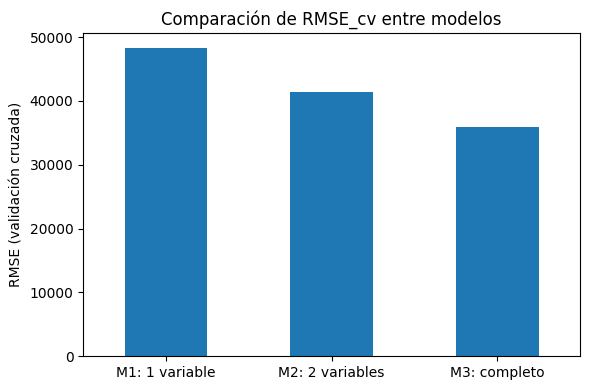

In [22]:
ax = cv_table["RMSE_cv_mean"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("RMSE (validación cruzada)")
ax.set_title("Comparación de RMSE_cv entre modelos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 8.6 Evaluación en el conjunto de prueba

Finalmente, entrenamos en el conjunto de entrenamiento y evaluamos en el conjunto de prueba:

- RMSE en test.  
- $R^2$ en test.


In [23]:
def fit_skl_lr_and_metrics(X_train, y_train, X_test, y_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    r2_test = r2_score(y_test, y_pred)
    return model, rmse_test, r2_test, y_pred

m1, rmse_test_m1, r2_test_m1, y_pred_m1 = fit_skl_lr_and_metrics(
    X_train_m1, y_train, X_test_m1, y_test
)
m2, rmse_test_m2, r2_test_m2, y_pred_m2 = fit_skl_lr_and_metrics(
    X_train_m2, y_train, X_test_m2, y_test
)
m3, rmse_test_m3, r2_test_m3, y_pred_m3 = fit_skl_lr_and_metrics(
    X_train_m3, y_train, X_test_m3, y_test
)

rmse_test_m1, rmse_test_m2, rmse_test_m3

(np.float64(48574.37748574204),
 np.float64(41046.49912283906),
 np.float64(34302.28068927086))

Tabla comparativa final (validación cruzada + prueba):

In [24]:
final_table = pd.DataFrame({
    "k_pred":        [X_train_m1.shape[1], X_train_m2.shape[1], X_train_m3.shape[1]],
    "AIC_train":     [ols_m1.aic, ols_m2.aic, ols_m3.aic],
    "BIC_train":     [ols_m1.bic, ols_m2.bic, ols_m3.bic],
    "RMSE_cv_mean":  [rmse_cv_m1, rmse_cv_m2, rmse_cv_m3],
    "RMSE_test":     [rmse_test_m1, rmse_test_m2, rmse_test_m3],
    "R2_test":       [r2_test_m1, r2_test_m2, r2_test_m3],
}, index=["M1: 1 variable", "M2: 2 variables", "M3: completo"]).round(4)

final_table

,k_pred,AIC_train,BIC_train,RMSE_cv_mean,RMSE_test,R2_test
M1: 1 variable,1,46933.1384,46944.2617,48251.3646,48574.3775,0.6263
M2: 2 variables,2,46356.1165,46372.8014,41455.0743,41046.4991,0.7331
M3: completo,12,45853.9547,45926.2560,35943.3636,34302.2807,0.8136


Podemos visualizar el RMSE en test para cada modelo:

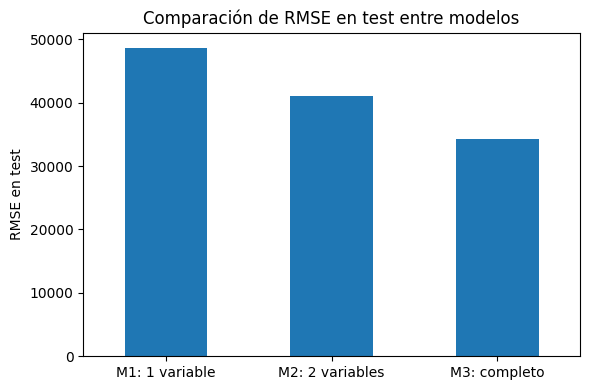

In [25]:
ax = final_table["RMSE_test"].plot(kind="bar", figsize=(6,4))
ax.set_ylabel("RMSE en test")
ax.set_title("Comparación de RMSE en test entre modelos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 8.7 Gráfico predicho vs observado para el modelo elegido

Elegimos el **modelo con mejor equilibrio** entre complejidad y desempeño (por ejemplo, el de menor RMSE en test o RMSE_cv).  
Aquí mostramos el gráfico de valores observados vs predichos para el modelo completo (M3) como referencia.


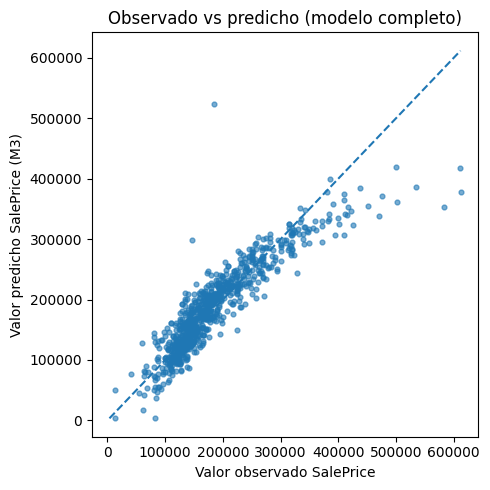

In [26]:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred_m3, s=12, alpha=0.6)
min_val = min(y_test.min(), y_pred_m3.min())
max_val = max(y_test.max(), y_pred_m3.max())
plt.plot([min_val, max_val], [min_val, max_val], "--")
plt.xlabel("Valor observado SalePrice")
plt.ylabel("Valor predicho SalePrice (M3)")
plt.title("Observado vs predicho (modelo completo)")
plt.tight_layout()
plt.show()

## 8.8 Key takeaways

- La **selección de modelo** debe balancear:
  - Ajuste (AIC, BIC).  
  - Complejidad (número de predictores).  
  - Desempeño predictivo (RMSE, $R^2$ en validación cruzada y test).  
- Modelos muy simples pueden tener sesgo alto; modelos muy complejos pueden sobreajustar.  
- La **validación cruzada k-fold** es una herramienta clave para estimar el error de generalización y comparar modelos de forma más robusta que mirar solo el error en entrenamiento.  

En el siguiente capítulo se estudiará cómo la **regularización (Ridge y Lasso)** ayuda a controlar la complejidad del modelo de manera continua.
